In [1]:
!nvidia-smi

Sat Jul  3 13:47:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

V100, P100, V4, K80

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential,Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import UpSampling2D, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import cifar100
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [40]:
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
X_val = X_train[40000:]
y_val = y_train[40000:]
X_train = X_train[:40000]
y_train = y_train[:40000]

In [41]:
x_train = applications.inception_resnet_v2.preprocess_input(X_train)
x_val = applications.inception_resnet_v2.preprocess_input(X_val)
x_test = applications.inception_resnet_v2.preprocess_input(X_test)

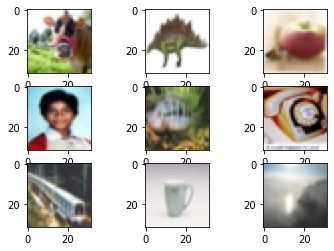

In [42]:
for i in range(9):
	# define subplot
	plt.subplot(330 + 1 + i)
	# plot raw pixel data
	plt.imshow(X_train[i])
# show the figure
plt.show()

In [43]:
onehot = OneHotEncoder(sparse=False)
y_train = onehot.fit_transform(y_train)
y_val = onehot.transform(y_val)
y_test = onehot.transform(y_test)

In [44]:
# initial hyper-parameter
batch_size = 32
num_classes = 100
epochs = 18
lrate = 1e-3
data_augmentation = True

##### Load a pretrained InceptionResNetV2 model without last FC layer (include_top=False) for Imagenet.

In [45]:
resnet_model = applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
resnet_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_406 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_408 (BatchN (None, 149, 149, 32) 96          conv2d_406[0][0]                 
__________________________________________________________________________________________________
activation_406 (Activation)     (None, 149, 149, 32) 0           batch_normalization_408[0][0]    
________________________________________________________________________________

In [46]:
model = Sequential([
        UpSampling2D(),
        UpSampling2D(),
        UpSampling2D(),
        resnet_model,
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        Dropout(0.3),
        BatchNormalization(),
        Dense(num_classes, activation='softmax')                   
])

In [47]:
opt = keras.optimizers.Adam(learning_rate=lrate)
model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['accuracy'])

In [33]:
# link folder Save model to drive
!ln -s /content/drive/'My Drive'/CW1/Save_model/content/

ln: failed to create symbolic link './content': File exists


In [48]:
save_dir = 'Save_model/'
model_name = 'model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [49]:
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)
callbacks = [checkpoint]

In [50]:
aug_train=ImageDataGenerator(rescale=1./255,rotation_range=30, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.2,zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
aug_val=ImageDataGenerator(rescale=1./255)

In [ ]:
if not data_augmentation:
    print('Not using Data Augmentation.')
    H = model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_val, y_val),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using Data Augmentation CutOut')
    # Data Augmentation
    # datagen = ImageDataGenerator(preprocessing_function=data_process(p=0.5))
    aug_train.fit(x_train)              
    H = model.fit(aug_train.flow(x_train, y_train, batch_size=batch_size),
                  steps_per_epoch=x_train.shape[0] // batch_size,
                  validation_data=aug_val.flow(x_val,y_val,batch_size=batch_size),
                  epochs=epochs, verbose=1,
                  callbacks=callbacks)

Using Data Augmentation CutOut
Epoch 1/18
1250/1250 [==============================] - 1035s 788ms/step - loss: 2.9493 - accuracy: 0.2628 - val_loss: 2.6528 - val_accuracy: 0.3365

Epoch 00001: val_accuracy improved from -inf to 0.33650, saving model to Save_model/model.h5
Epoch 2/18
1250/1250 [==============================] - 981s 785ms/step - loss: 2.0566 - accuracy: 0.4388 - val_loss: 3.0114 - val_accuracy: 0.3270

Epoch 00002: val_accuracy did not improve from 0.33650
Epoch 3/18
1250/1250 [==============================] - 980s 784ms/step - loss: 1.7812 - accuracy: 0.5074 - val_loss: 1.9224 - val_accuracy: 0.4914

Epoch 00003: val_accuracy improved from 0.33650 to 0.49140, saving model to Save_model/model.h5
Epoch 4/18
1250/1250 [==============================] - 980s 784ms/step - loss: 1.5955 - accuracy: 0.5516 - val_loss: 1.6067 - val_accuracy: 0.5642

Epoch 00004: val_accuracy improved from 0.49140 to 0.56420, saving model to Save_model/model.h5
Epoch 5/18
1250/1250 [==========

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


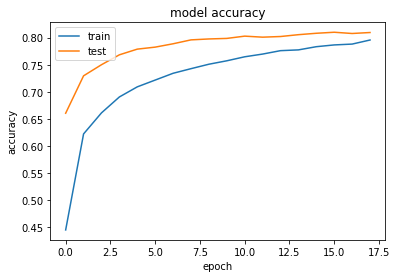

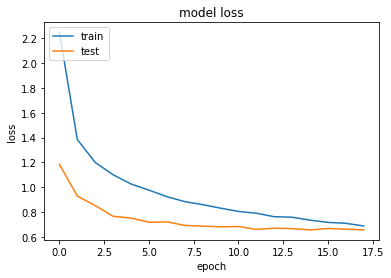

In [ ]:
print(H.history.keys())
# summarize history for accuracy
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 86s 276ms/step - loss: 0.6296 - accuracy: 0.8186
Test loss: 0.6296
Test accuracy: 0.8186


In [ ]:
model = load_model("Save_model/model.h5")
score = model.evaluate(x_test, y_test)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

313/313 [==============================] - 86s 276ms/step - loss: 0.6340 - accuracy: 0.8122
Test loss: 0.6340
Test accuracy: 0.8122


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling2d_7 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 multiple                  0         
_________________________________________________________________
up_sampling2d_9 (UpSampling2 multiple                  0         
_________________________________________________________________
inception_resnet_v2 (Model)  (None, 8, 8, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( multiple                  0         
_________________________________________________________________
dense_4 (Dense)              multiple                  786944    
_________________________________________________________________
dropout_2 (Dropout)          multiple                 

In [ ]:
!kill -9 -1